In [1]:
import math
import json
import pandas as pd
from tqdm import tqdm
import sqlite3
import matplotlib.pyplot as plt
from utils import draw_venn

In [2]:
pd.options.mode.chained_assignment = None
DATA_DIR = "../data"

# Connecting to ChEMBL database

In [3]:
conn = sqlite3.connect(f"{DATA_DIR}/chembl_33/chembl_33_sqlite/chembl_33.db")

In [4]:
cursor = conn.execute("SELECT name from sqlite_master WHERE type='table';")

In [5]:
try:
    assert len(cursor.fetchall()) > 1
except AssertionError:
    print(
        "Corrupted database. Please download the database dump again from \
    - https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/"
    )

# Get all bioactivity data

In [6]:
sql = """
SELECT
    MOLECULE_DICTIONARY.pref_name,
    MOLECULE_DICTIONARY.molregno as chembl_id,
    COMPOUND_STRUCTURES.canonical_smiles,
    COMPOUND_STRUCTURES.standard_inchi,
    COMPOUND_STRUCTURES.standard_inchi_key,
    ACTIVITIES.standard_relation,
    ACTIVITIES.standard_type,
    ACTIVITIES.standard_value,
    ACTIVITIES.standard_units,
    ASSAYS.assay_organism as ORGANISM,
    ASSAYS.assay_strain as STRAIN,
    ASSAYS.assay_tax_id,
    ASSAYS.chembl_id as assay_id
FROM MOLECULE_DICTIONARY
JOIN ACTIVITIES ON MOLECULE_DICTIONARY.molregno == ACTIVITIES.molregno
JOIN ASSAYS ON ACTIVITIES.assay_id == ASSAYS.assay_id
JOIN COMPOUND_STRUCTURES on COMPOUND_STRUCTURES.molregno == MOLECULE_DICTIONARY.molregno
WHERE
    ACTIVITIES.standard_value is not null
    and ASSAYS.assay_organism is not null
    and ACTIVITIES.standard_type in ("MIC", "MIC50")
"""

In [7]:
bioactivity_data = pd.read_sql(sql=sql, con=conn)

In [8]:
bioactivity_data.head(2)

,pref_name,chembl_id,canonical_smiles,standard_inchi,standard_inchi_key,standard_relation,standard_type,standard_value,standard_units,ORGANISM,STRAIN,assay_tax_id,assay_id
0,KANAMYCIN SULFATE,378124,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,InChI=1S/C18H36N4O11.H2O4S/c19-2-6-10(25)12(27...,OOYGSFOGFJDDHP-KMCOLRRFSA-N,=,MIC,7.8,ug.mL-1,Staphylococcus aureus,None,1280.0,CHEMBL811149
1,KANAMYCIN SULFATE,378124,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,InChI=1S/C18H36N4O11.H2O4S/c19-2-6-10(25)12(27...,OOYGSFOGFJDDHP-KMCOLRRFSA-N,=,MIC,15.6,ug.mL-1,Streptococcus pyogenes,None,1314.0,CHEMBL814983


# Map bacterial classes to data

In [9]:
bac_dic = json.load(open(f"{DATA_DIR}/mapping/bact_mapper.json"))
len(bac_dic)

2052

In [10]:
bioactivity_data["bact_class"] = bioactivity_data["ORGANISM"].map(bac_dic)

In [11]:
m = bioactivity_data["bact_class"].isna()
bioactivity_data = bioactivity_data[~m]

In [12]:
m1 = bioactivity_data["standard_units"].isin(["ug.mL-1"])
m2 = bioactivity_data["standard_relation"] == "="
subset_bioactivity_data = bioactivity_data[m1 & m2]
subset_bioactivity_data.shape

(449504, 14)

In [13]:
subset_bioactivity_data.head()

,pref_name,chembl_id,canonical_smiles,standard_inchi,standard_inchi_key,standard_relation,standard_type,standard_value,standard_units,ORGANISM,STRAIN,assay_tax_id,assay_id,bact_class
0,KANAMYCIN SULFATE,378124,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,InChI=1S/C18H36N4O11.H2O4S/c19-2-6-10(25)12(27...,OOYGSFOGFJDDHP-KMCOLRRFSA-N,=,MIC,7.8,ug.mL-1,Staphylococcus aureus,None,1280.0,CHEMBL811149,gram-positive
1,KANAMYCIN SULFATE,378124,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,InChI=1S/C18H36N4O11.H2O4S/c19-2-6-10(25)12(27...,OOYGSFOGFJDDHP-KMCOLRRFSA-N,=,MIC,15.6,ug.mL-1,Streptococcus pyogenes,None,1314.0,CHEMBL814983,gram-positive
2,KANAMYCIN SULFATE,378124,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,InChI=1S/C18H36N4O11.H2O4S/c19-2-6-10(25)12(27...,OOYGSFOGFJDDHP-KMCOLRRFSA-N,=,MIC,250.0,ug.mL-1,Enterococcus faecalis,None,1351.0,CHEMBL810032,gram-positive
3,KANAMYCIN SULFATE,378124,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,InChI=1S/C18H36N4O11.H2O4S/c19-2-6-10(25)12(27...,OOYGSFOGFJDDHP-KMCOLRRFSA-N,=,MIC,125.0,ug.mL-1,Streptococcus pneumoniae,None,1313.0,CHEMBL810961,gram-positive
4,KANAMYCIN SULFATE,378124,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,InChI=1S/C18H36N4O11.H2O4S/c19-2-6-10(25)12(27...,OOYGSFOGFJDDHP-KMCOLRRFSA-N,=,MIC,3.9,ug.mL-1,Escherichia coli,None,562.0,CHEMBL676856,gram-negative


In [14]:
subset_bioactivity_data["chembl_id"].nunique(), subset_bioactivity_data[
    "assay_id"
].nunique(), subset_bioactivity_data["ORGANISM"].nunique()

(64881, 63090, 1626)

In [15]:
subset_bioactivity_data["bact_class"].value_counts()

gram-positive    196180
gram-negative    154379
fungi             75480
acid-fast         23465
Name: bact_class, dtype: int64

# Check compound overlap

In [16]:
compound_dict = {}

for inchikey, class_name in tqdm(
    zip(
        subset_bioactivity_data["standard_inchi_key"],
        subset_bioactivity_data["bact_class"],
    ),
    total=len(subset_bioactivity_data),
):
    if class_name not in compound_dict:
        compound_dict[class_name] = set()

    compound_dict[class_name].add(inchikey)

100%|██████████| 449504/449504 [00:00<00:00, 2014476.30it/s]


In [17]:
total_compounds = set()
for i in compound_dict:
    print(i, len(compound_dict[i]))
    total_compounds.update(compound_dict[i])

print(f"Total compounds: {len(total_compounds)}")

gram-positive 42956
gram-negative 32627
fungi 17770
acid-fast 11205
Total compounds: 64881


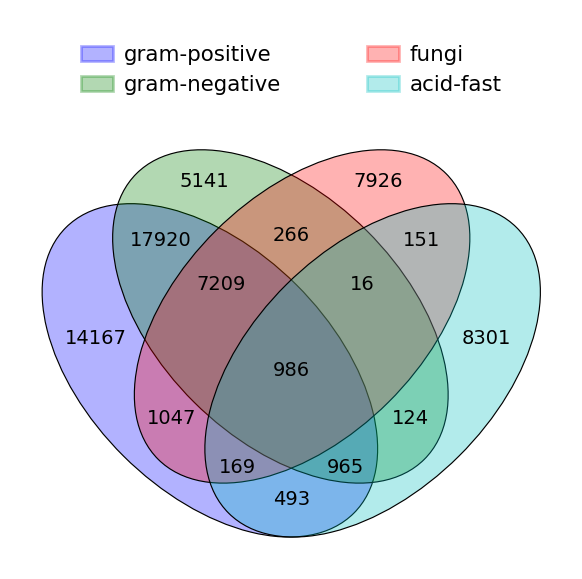

In [18]:
draw_venn(sets=compound_dict)

# Normalizing to pChEMBL values

In [19]:
subset_bioactivity_data["standard_units"] = subset_bioactivity_data[
    "standard_units"
].replace("ug.mL-1", "uM")

In [20]:
subset_bioactivity_data["standard_units"].value_counts()

uM    449504
Name: standard_units, dtype: int64

In [21]:
def calculate_pmic(row):
    if row["standard_value"] == 0.0:
        return 0
    elif str(row["standard_value"]).startswith("-"):  # certain neagtive vlaues found
        return 0
    elif row["standard_units"] == "nM" and pd.notna(row["standard_value"]):
        return round(9 - math.log10(float(row["standard_value"])))
    elif row["standard_units"] == "uM" and pd.notna(row["standard_value"]):
        return round(6 - math.log10(float(row["standard_value"])))
    elif row["standard_units"] == "mM" and pd.notna(row["standard_value"]):
        return round(3 - math.log10(float(row["standard_value"])))
    else:
        return 0


subset_bioactivity_data["pmic"] = subset_bioactivity_data.apply(calculate_pmic, axis=1)

<AxesSubplot: ylabel='Frequency'>

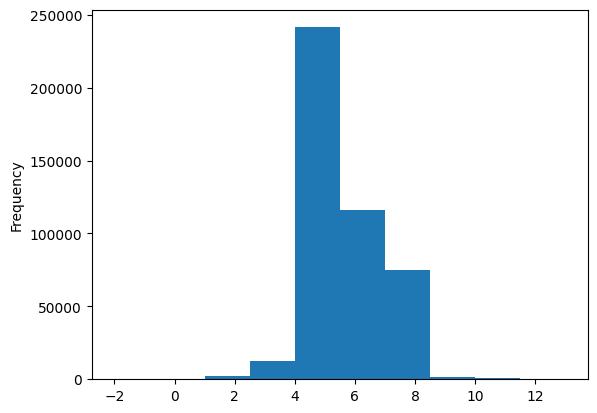

In [22]:
subset_bioactivity_data["pmic"].plot(kind="hist")

In [23]:
subset_bioactivity_data.head(2)

,pref_name,chembl_id,canonical_smiles,standard_inchi,standard_inchi_key,standard_relation,standard_type,standard_value,standard_units,ORGANISM,STRAIN,assay_tax_id,assay_id,bact_class,pmic
0,KANAMYCIN SULFATE,378124,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,InChI=1S/C18H36N4O11.H2O4S/c19-2-6-10(25)12(27...,OOYGSFOGFJDDHP-KMCOLRRFSA-N,=,MIC,7.8,uM,Staphylococcus aureus,None,1280.0,CHEMBL811149,gram-positive,5
1,KANAMYCIN SULFATE,378124,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,InChI=1S/C18H36N4O11.H2O4S/c19-2-6-10(25)12(27...,OOYGSFOGFJDDHP-KMCOLRRFSA-N,=,MIC,15.6,uM,Streptococcus pyogenes,None,1314.0,CHEMBL814983,gram-positive,5


In [24]:
subset_bioactivity_data.to_csv(
    f"{DATA_DIR}/processed/chembl33_raw_data.tsv", sep="\t", index=False
)

In [25]:
data = []

for inchikey in tqdm(subset_bioactivity_data["standard_inchi_key"].unique()):
    tmp = subset_bioactivity_data[
        subset_bioactivity_data["standard_inchi_key"] == inchikey
    ]

    data_dict = {
        "compound_inchikey": inchikey,
        "compound_smiles": tmp["canonical_smiles"].values[0],
        "compound_source": "chembl_33",
    }

    for bact_class_name in ["gram-positive", "gram-negative", "fungi", "acid-fast"]:
        t = tmp[tmp["bact_class"] == bact_class_name]
        if t.shape[0] == 0:
            data_dict[bact_class_name] = None
        elif t.shape[0] == 1:
            data_dict[bact_class_name] = t["pmic"].values[0]
        else:
            data_dict[bact_class_name] = t["pmic"].median()

    data.append(data_dict)

100%|██████████| 64881/64881 [18:20<00:00, 58.98it/s]


In [26]:
final_df = pd.DataFrame(data)
final_df.head()

,compound_inchikey,compound_smiles,compound_source,gram-positive,gram-negative,fungi,acid-fast
0,OOYGSFOGFJDDHP-KMCOLRRFSA-N,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,chembl_33,5.0,5.0,NaN,6.0
1,XIPHLJFTBFXVBS-UHFFFAOYSA-N,C=C(C(=O)c1ccc(F)cc1)c1ccc(Cl)cc1Cl,chembl_33,NaN,NaN,6.0,NaN
2,OEFUWWDPRNNMRS-WDPNLORNSA-N,CC[C@H]1OC(=O)[C@H](C)[C@H]2OC3(CCN(C(=O)c4ccc...,chembl_33,6.0,6.5,NaN,NaN
3,LBRXTHSVIORIGU-OLROFJLRSA-N,CC[C@H]1OC(=O)[C@H](C)[C@H]2OC3(CCN(C(=O)c4cnc...,chembl_33,6.0,6.0,NaN,NaN
4,PHYLUFIYANLQSE-UHFFFAOYSA-N,CN1Cc2csc3c(C(=O)O)c(=O)c4cc(F)c(N5CCOC(CF)C5)...,chembl_33,7.5,7.0,NaN,NaN


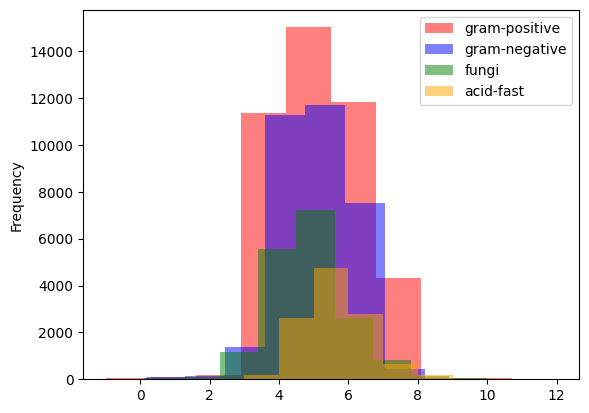

In [27]:
fig, ax = plt.subplots(1, 1)
final_df["gram-positive"].plot(kind="hist", ax=ax, alpha=0.5, color="red")
final_df["gram-negative"].plot(kind="hist", ax=ax, alpha=0.5, color="blue")
final_df["fungi"].plot(kind="hist", ax=ax, alpha=0.5, color="green")
final_df["acid-fast"].plot(kind="hist", ax=ax, alpha=0.5, color="orange")
plt.legend()
plt.show()

In [28]:
final_df.to_csv(f"{DATA_DIR}/processed/bacterial_chembl_33.tsv", sep="\t", index=False)